In [1]:
%matplotlib inline


Training an AlexNet Classifier for Cifar10
=====================

## Alexnet
AlexNet is designed by Alex Krizhevsky, and published with Ilya Sutskever and Krizhevsky's doctoral advisor Geoffrey Hinton in "ImageNet classification with deep convolutional neural networks", [NIPS 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf "NIPS'12 link"). 

AlexNet wins the championship of ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) during training. 

Original AlexNet receives inputs of 3x224x224 color images with 1000-class outputs:  

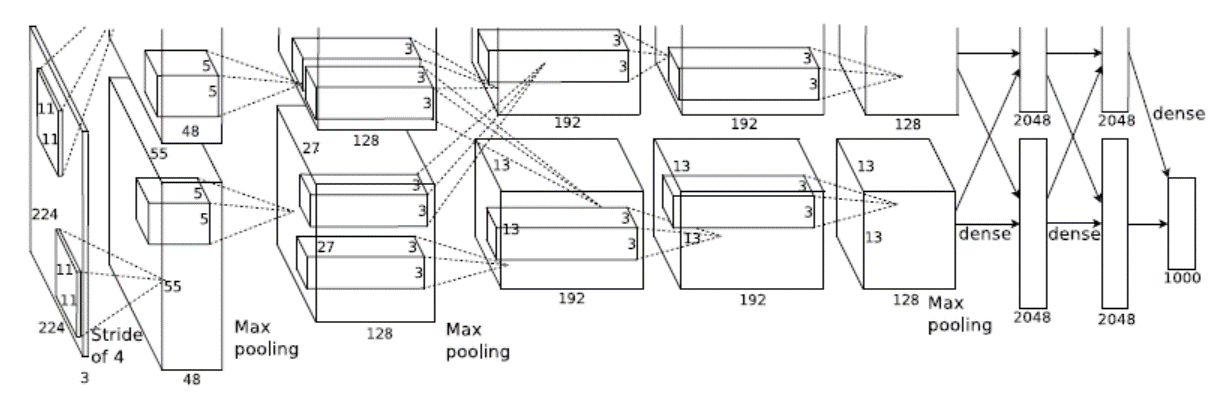

In [2]:
from IPython.display import Image
Image(filename='graphics/AlexNet.png')
# <img src="./graphics/AlexNet.PNG" alt="drawing" width="1200"/>

Our simplified version below is tailored for Cifar10 dataset of 3x32x32 color image inputs and 10-class outputs.

In [3]:
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), #nn.Dropout(p=0.5,inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), #nn.Dropout(p=0.5,inplace=True),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.classifier(x)
        return x


def alexnet(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet(**kwargs)
    return model


In [4]:
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, o

In [5]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
use_gpu = torch.cuda.is_available()

device = torch.device("cuda:2" if use_gpu else "cpu")
print(device)

if use_gpu:
    model = model.cuda()

cuda:2


In [6]:
# Show basic information of model
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install torchsummary

from torchsummary import summary

summary(model, input_size=(3, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]          23,296
              ReLU-2             [-1, 64, 8, 8]               0
         MaxPool2d-3             [-1, 64, 4, 4]               0
            Conv2d-4            [-1, 192, 4, 4]         307,392
              ReLU-5            [-1, 192, 4, 4]               0
         MaxPool2d-6            [-1, 192, 2, 2]               0
            Conv2d-7            [-1, 384, 2, 2]         663,936
              ReLU-8            [-1, 384, 2, 2]               0
            Conv2d-9            [-1, 256, 2, 2]         884,992
             ReLU-10            [-1, 256, 2, 2]               0
           Conv2d-11            [-1, 256, 2, 2]         590,080
             ReLU-12            [-1, 256, 2, 2]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
           Linear-14                  [

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [7]:
# Loading and normalizing CIFAR10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size_train = 100 # 200
batch_size_test = 100  # 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=False, num_workers=2)

loaders = {'train': trainloader, 'test': testloader}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 frog horse   dog   dog


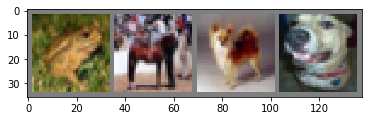

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Training on GPU
----------------
We are going to define a function to train a model on GPU, record the training (test) loss and errors, then plot them.

In [9]:
# Define a function for training process, returning training (test) loss and errors
import os
import re
import time
import scipy.stats

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

#            if phase != 'train':
            print(
                    f'{phase} loss: {epoch_loss:.4f}; error: {epoch_error:.4f}'
            )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

In [10]:
# The log for recording train (test) loss and errors.
log = {
    'num_params': [],
    'train_loss': [],
    'train_error': [],
    'test_loss': [],
    'test_error': []
}

In [11]:
# Training parameters
num_epochs = 30
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
momentum = 0.9


In [12]:
number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log['num_params'].append(number_params)

print(f'total parameters: {number_params}')

total parameters: 2603850


In [13]:
# Train the model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model, log = train_model(
    model, criterion, optimizer, log, num_epochs=num_epochs)

Epoch 1/30
----------
train loss: 2.3030; error: 0.8993
test loss: 2.3029; error: 0.9000
Saving..
Epoch 2/30
----------


/home/yuany/.conda/envs/mypython3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train loss: 2.3028; error: 0.8978
test loss: 2.3020; error: 0.9000
Epoch 3/30
----------
train loss: 2.2849; error: 0.8750
test loss: 2.1263; error: 0.8163
Epoch 4/30
----------
train loss: 1.9828; error: 0.8061
test loss: 1.8868; error: 0.7479
Epoch 5/30
----------
train loss: 1.8141; error: 0.7249
test loss: 1.6601; error: 0.6457
Epoch 6/30
----------
train loss: 1.6457; error: 0.6441
test loss: 1.5391; error: 0.6028
Epoch 7/30
----------
train loss: 1.5308; error: 0.5904
test loss: 1.4443; error: 0.5641
Epoch 8/30
----------
train loss: 1.4279; error: 0.5401
test loss: 1.3569; error: 0.5026
Epoch 9/30
----------
train loss: 1.3027; error: 0.4813
test loss: 1.2516; error: 0.4608
Epoch 10/30
----------
train loss: 1.1985; error: 0.4368
test loss: 1.2251; error: 0.4345
Epoch 11/30
----------
train loss: 1.0866; error: 0.3898
test loss: 1.2026; error: 0.4166
Epoch 12/30
----------
train loss: 0.9892; error: 0.3515
test loss: 1.1259; error: 0.3830
Epoch 13/30
----------
train loss: 0.898

In [14]:
# Plot the results:

def plot(log, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')

    ax1.plot(log['train_loss'],'b', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'r', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'b', linewidth=3, label='training')
    ax2.plot(log['test_error'],'r', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)

    for ax in [ax1, ax2]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)
        
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')


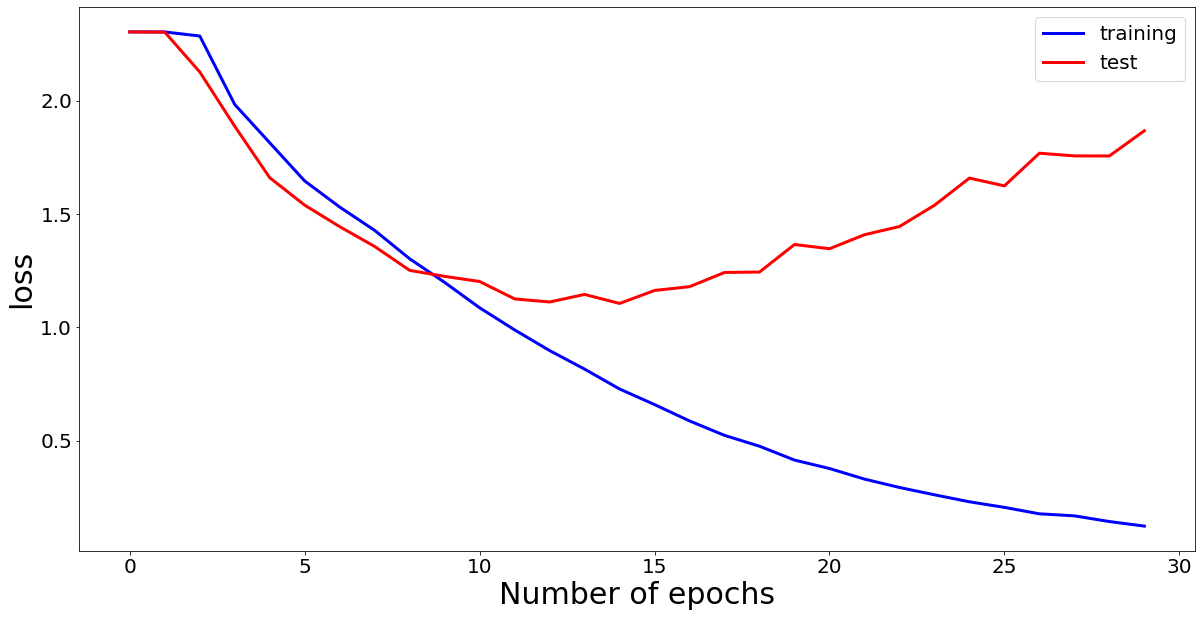

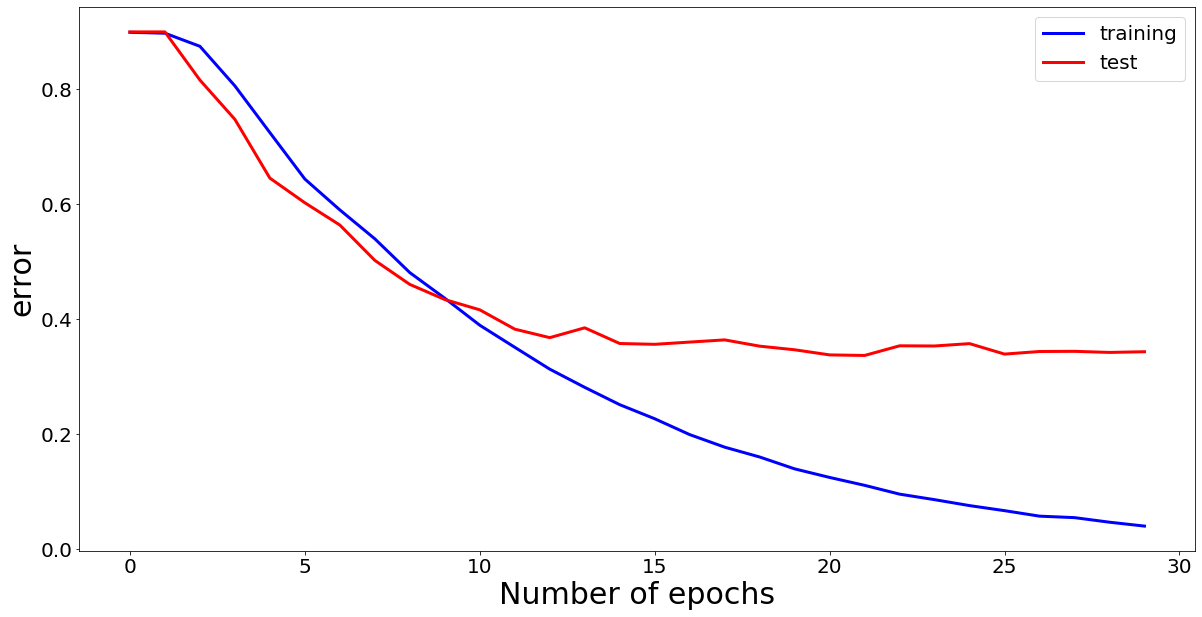

In [15]:
plot(log, './alex_results/')
plt.show()